# Модели камер

In [1]:
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
import cv2

## Модели камер с точечной диафрагмой

Проецированиеи точек трехмерного пространства. Создадим класс камеры для моделирования и проецирования

In [2]:
class Camera(object):
    def __init__(self, P):
        'Модель камеры P=K[R|t]'
        self.P = P
        self.K = None # калибровочная матрица
        self.R = None # поворот
        self.t = None # параллельный перенос
        self.c = None # центр камеры

    def project(self, X):
        'спроецировать точки из массива Х (4*n) и нормировать координаты'
        x = np.dot(self.P, X)
        for i in range(3):
            x[i] /= x[2]
        return x

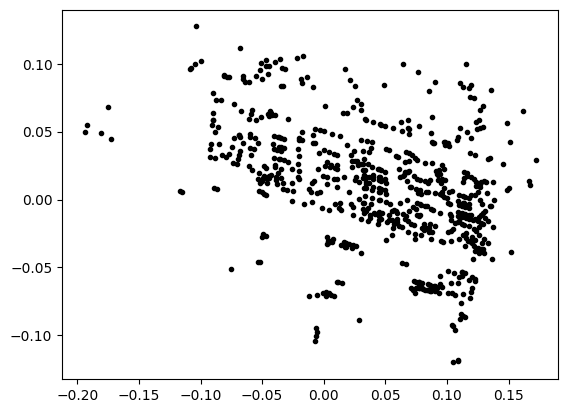

In [3]:
# загрузить тoчки
points = np.loadtxt('3D/house.p3d').T
points = np.vstack((points, np.ones(points.shape[1])))

# настроить камеру
P = np.hstack((np.eye(3), np.array([[0], [0], [-10]])))
cam = Camera(P)
x = cam.project(points)

plt.figure()
plt.plot(x[0], x[1], 'k.')
plt.show()

Повернем камеру

In [4]:
def rotation_matrix(a):
    """    Creates a 3D rotation matrix for rotation
        around the axis of the vector a. """
    R = np.eye(4)
    R[:3,:3] = linalg.expm([[0,-a[2],a[1]],[a[2],0,-a[0]],[-a[1],a[0],0]])
    return R

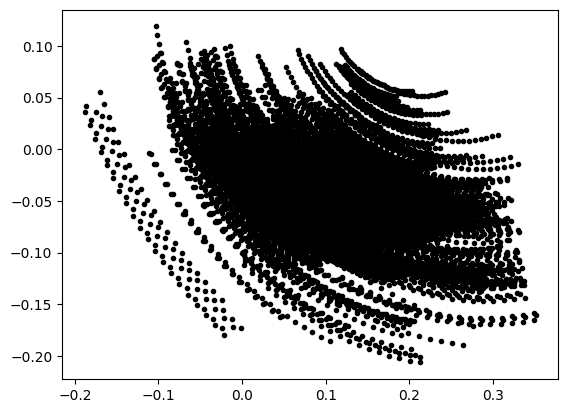

In [5]:
# создать преобразование
r = 0.05 * np.random.rand(3)
rot = rotation_matrix(r)

# повернуть камеру и спроецировать 
plt.figure()
for t in range(20):
    cam.P = np.dot(cam.P, rot)
    x = cam.project(points)
    plt.plot(x[0], x[1], 'k.')
plt.show()


### Разложение матрицы камеры

In [6]:
K = np.array([[1000, 0, 500], [0, 1000, 300], [0, 0, 1]])
tmp = rotation_matrix([0, 0, 1])[:3, :3]
Rt = np.hstack((tmp, np.array([[50], [40], [30]])))
cam = Camera(np.dot(K, Rt))

print(K, Rt)
print(cam.factor())

[[1000    0  500]
 [   0 1000  300]
 [   0    0    1]] [[ 0.54030231 -0.84147098  0.         50.        ]
 [ 0.84147098  0.54030231  0.         40.        ]
 [ 0.          0.          1.         30.        ]]
(array([[ 1.00000000e+03,  2.27373675e-13,  5.00000000e+02],
       [ 0.00000000e+00, -1.00000000e+03,  3.00000000e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]), array([[ 0.54030231, -0.84147098,  0.        ],
       [-0.84147098, -0.54030231,  0.        ],
       [ 0.        ,  0.        ,  1.        ]]), array([ 50., -40.,  30.]))


### Вычисление центра камеры

In [ ]:
def center(self):
        """    Compute and return the camera center. """
    
        if self.c is not None:
            return self.c
        else:
            # compute c by factoring
            self.factor()
            self.c = -np.dot(self.R.T,self.t)
            return self.c

## Калибровка камеры

- Измерить стороны прямоугольного калибровочного объекта. Обозначим их dX и dУ.
- Положить камеру и калибровочный объект на плоскую поверхность, так чтобы обратная сторона камеры была параллельна объекту и объект находился примерно в центре поля
зрения камеры. Для лучшего совмещения, возможно, придется приподнять камеру или объект.
- Измерить расстояние между камерой и калибровочным объектом. Обозначим его dZ.
- Сделать снимок и проверить, что стороны объекта совмещаются со строками и столбцами матрицы изображения.
- Измерить ширину и высоту объекта в пикселях. Обозначим их dx u dy.

$$
f_xx = \frac{dx}{dX}dZ, f_y=\frac{dy}{dY}dZ
$$

$$
K=\begin{bmatrix}
f_x & 0 & c_x \\
0 & f_y & c_y\\
0 & 0   & 1 \\
\end{bmatrix}
$$

## Оценивание положения по плоскостям и маркерам

In [2]:
img1 = cv2.imread('pics/book_frontal.JPG', cv2.IMREAD_GRAYSCALE)  # Первое изображение
img2 = cv2.imread('pics/book_perspective.JPG', cv2.IMREAD_GRAYSCALE)  # Второе изображение

In [6]:
# Инициализация SIFT
sift = cv2.SIFT_create()

# Поиск ключевых точек и дескрипторов с помощью SIFT
keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

# Поиск совпадений с использованием метода Фланна (FLANN)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descriptors1, descriptors2, k=2)

# Применение метода Lowe's Ratio Test для отбора лучших совпадений
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Проверяем, достаточно ли найдено хороших совпадений
if len(good_matches) > 10:
    # Извлечение координат ключевых точек из хороших совпадений
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Вычисление матрицы гомографии с использованием RANSAC
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # Применение матрицы гомографии для трансформации изображения
    height, width = img2.shape
    img1_warped = cv2.warpPerspective(img1, H, (width, height))

    # Отображение результата
    cv2.imshow("Warped Image", img1_warped)
    cv2.imshow("Original Image", img2)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("Недостаточно хороших совпадений для вычисления гомографии.")

In [7]:
# В виде функции
def find_homography(img1, img2):
    """
    Функция для вычисления матрицы гомографии между двумя изображениями
    с использованием SIFT для поиска ключевых точек и RANSAC для отбора совпадений.
    
    :param img1: Первое изображение (в формате numpy массива)
    :param img2: Второе изображение (в формате numpy массива)
    :return: Матрица гомографии H или None, если совпадений недостаточно.
    """
    # Преобразование изображений в градации серого, если они цветные
    if len(img1.shape) == 3:
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    if len(img2.shape) == 3:
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Инициализация SIFT
    sift = cv2.SIFT_create()

    # Поиск ключевых точек и дескрипторов с помощью SIFT
    keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

    # Поиск совпадений с использованием метода Фланна (FLANN)
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)

    # Применение метода Lowe's Ratio Test для отбора лучших совпадений
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # Проверяем, достаточно ли найдено хороших совпадений
    if len(good_matches) > 10:
        # Извлечение координат ключевых точек из хороших совпадений
        src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        # Вычисление матрицы гомографии с использованием RANSAC
        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        return H
    else:
        print("Недостаточно хороших совпадений для вычисления гомографии.")
        return None

In [8]:
H = find_homography(img1, img2)
print(H)

[[-4.16190504e-01 -5.24887552e-01  8.89846458e+02]
 [ 3.09522305e-01 -2.19018785e-01  2.12424808e+02]
 [-3.31058747e-04  7.52915600e-05  1.00000000e+00]]
